# Satellite-Based Tree Crown Width Extraction

## Goal: Extract crown width measurements from satellite imagery using lat/long coordinates

This notebook will:
1. Load tree location data (lat/long)
2. Fetch satellite imagery for tree locations
3. Process images to detect tree crowns
4. Measure crown width
5. Store results for model integration


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
import cv2
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load tree data with coordinates
tree_df = pd.read_csv('../../data/tree_prioritization_features.csv', low_memory=False)

# Filter to trees with valid coordinates and DBH > 0
tree_df = tree_df[
    (tree_df['Latitude'].notna()) & 
    (tree_df['Longitude'].notna()) &
    (tree_df['DBH'] > 0)
].copy()

print(f"Loaded {len(tree_df):,} trees with valid coordinates")
print(f"\nCoordinate ranges:")
print(f"Latitude: {tree_df['Latitude'].min():.6f} to {tree_df['Latitude'].max():.6f}")
print(f"Longitude: {tree_df['Longitude'].min():.6f} to {tree_df['Longitude'].max():.6f}")

# Show sample
print(f"\nSample tree data:")
print(tree_df[['Site ID', 'Latitude', 'Longitude', 'DBH', 'Species_Simple']].head())


Loaded 189,103 trees with valid coordinates

Coordinate ranges:
Latitude: 42.920949 to 43.190140
Longitude: -88.064927 to -87.868733

Sample tree data:
   Site ID   Latitude  Longitude   DBH Species_Simple
0   166587  42.982287 -87.912201  12.0          MAPLE
1   166592  42.982285 -87.912369   4.0           PEAR
2   166828  42.982162 -87.911876  12.0          MAPLE
3   166831  42.982124 -87.912015  17.0          MAPLE
4   166834  42.982006 -87.912013   3.0    HONEYLOCUST


## Satellite Image Fetching

### Comparison: Google Maps Static API vs Google Earth Engine

| Feature | Google Maps Static API | Google Earth Engine |
|---------|----------------------|---------------------|
| **Setup Difficulty** | ⭐ Easy (just API key) | ⭐⭐ Moderate (auth + API) |
| **Cost** | 💰 Paid (free tier: $200/month) | ✅ Free for research/education |
| **Resolution** | ~0.1-0.5m (varies by location) | 0.5m (commercial) or 10m (Sentinel-2) |
| **Image Quality** | High (commercial imagery) | High (multiple sources) |
| **Historical Data** | ❌ Current only | ✅ Full archive (decades) |
| **NDVI/Indices** | ❌ No | ✅ Yes (built-in) |
| **Batch Processing** | ⚠️ Rate limited | ✅ Optimized for large scale |
| **Time Series** | ❌ No | ✅ Yes |
| **Best For** | Quick prototyping, current imagery | Research, analysis, historical trends |

**Recommendation for Crown Width:**
- **Google Maps Static API**: Better for individual tree detail (higher resolution, easier setup)
- **Google Earth Engine**: Better for large-scale analysis, NDVI extraction, temporal analysis

**We'll implement both options below!**


In [ ]:
# Configuration for satellite imagery
import os
from dotenv import load_dotenv

# Load environment variables from .env file (if it exists)
# This will also read from system environment variables
load_dotenv()

# API Key - reads from .env file or environment variable
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY', 'NO API KEY')

# Image parameters
ZOOM_LEVEL = 20  # Higher = more detail (1-20, 20 is street level detail)
IMAGE_SIZE = '640x640'  # Max 640x640 for free tier
MAP_TYPE = 'satellite'  # 'satellite', 'hybrid', or 'terrain'

# Area to capture around each tree (in meters)
# This determines the field of view - adjust based on typical crown sizes
AREA_SIZE_METERS = 30  # 30m x 30m area around tree

def get_satellite_image(lat, lon, zoom=ZOOM_LEVEL, size=IMAGE_SIZE, api_key=GOOGLE_MAPS_API_KEY):
    """
    Fetch satellite image from Google Maps Static API
    
    Parameters:
    - lat: Latitude
    - lon: Longitude  
    - zoom: Zoom level (1-20)
    - size: Image size (e.g., '640x640')
    - api_key: Google Maps API key
    
    Returns:
    - PIL Image object or None if failed
    """
    if api_key == 'YOUR_API_KEY_HERE':
        print("Warning: Please set your Google Maps API key!")
        return None
    
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        'center': f'{lat},{lon}',
        'zoom': zoom,
        'size': size,
        'maptype': MAP_TYPE,
        'key': api_key
    }
    
    try:
        response = requests.get(base_url, params=params, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            return img
        else:
            print(f"Error fetching image: Status {response.status_code}")
            print(f"Response: {response.text[:200]}")
            return None
    except Exception as e:
        print(f"Error fetching satellite image: {e}")
        return None

print("Satellite image fetching function ready!")
print(f"\nNote: Current zoom level: {ZOOM_LEVEL} (adjust for desired detail)")
print(f"Area coverage: ~{AREA_SIZE_METERS}m x {AREA_SIZE_METERS}m per image")


Satellite image fetching function ready!

Note: Current zoom level: 20 (adjust for desired detail)
Area coverage: ~30m x 30m per image


Testing with tree Site ID: 166587
Location: (42.982287, -87.912201)
Species: MAPLE, DBH: 12.0"

✓ Successfully fetched image!
Image size: (640, 640)
Image mode: P


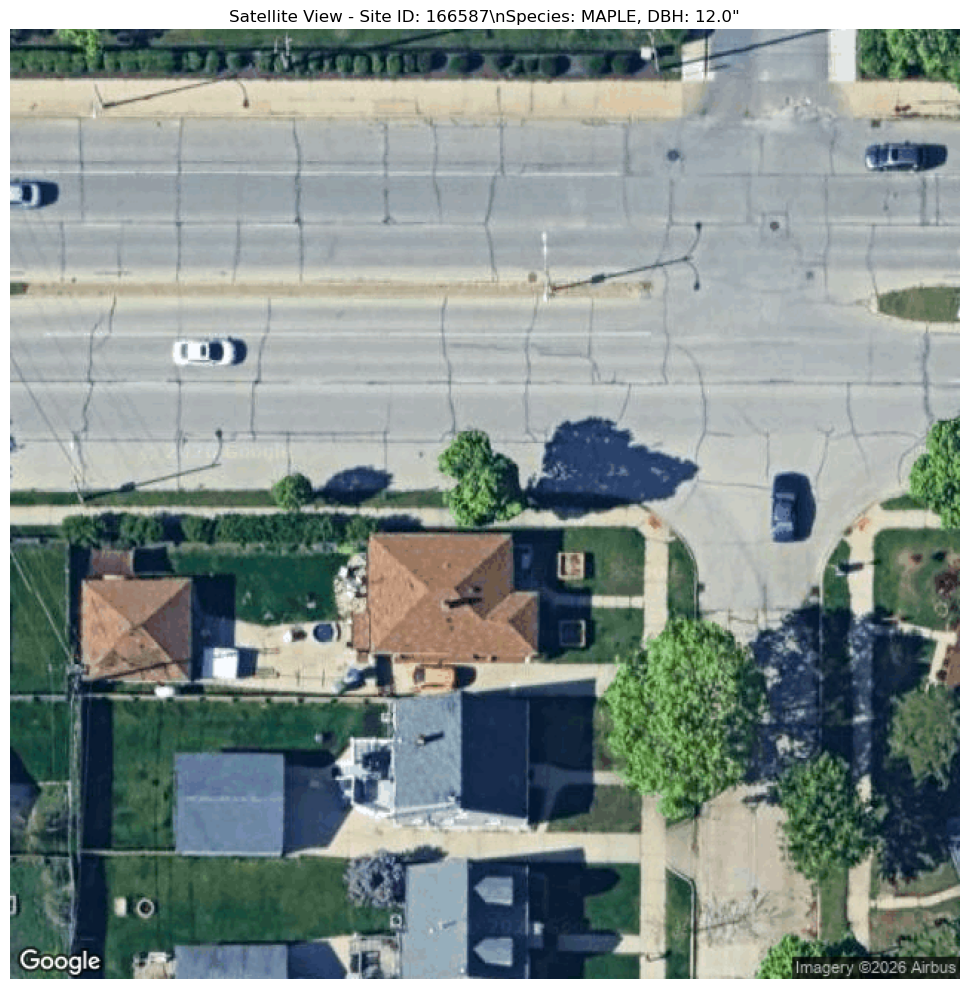

In [12]:
# Test with a sample tree (first tree in dataset)
sample_tree = tree_df.iloc[0]
print(f"Testing with tree Site ID: {sample_tree['Site ID']}")
print(f"Location: ({sample_tree['Latitude']:.6f}, {sample_tree['Longitude']:.6f})")
print(f"Species: {sample_tree['Species_Simple']}, DBH: {sample_tree['DBH']:.1f}\"")

# Fetch satellite image
test_image = get_satellite_image(
    sample_tree['Latitude'], 
    sample_tree['Longitude'],
    zoom=ZOOM_LEVEL
)

if test_image:
    print(f"\n✓ Successfully fetched image!")
    print(f"Image size: {test_image.size}")
    print(f"Image mode: {test_image.mode}")
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(test_image)
    plt.title(f"Satellite View - Site ID: {sample_tree['Site ID']}\\n"
              f"Species: {sample_tree['Species_Simple']}, DBH: {sample_tree['DBH']:.1f}\"")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\\n✗ Failed to fetch image. Please check your API key and internet connection.")


## Crown Detection and Width Measurement

We'll use computer vision techniques to:
1. Convert image to appropriate color space
2. Segment tree crowns (green vegetation)
3. Detect individual tree crowns
4. Measure crown width in pixels
5. Convert to real-world measurements (meters)


In [19]:
def meters_per_pixel(lat, zoom_level):
    """
    Calculate meters per pixel at given latitude and zoom level
    Based on Google Maps projection
    """
    # Earth's circumference at equator (meters)
    earth_circumference = 40075017
    
    # Pixels per tile at given zoom
    pixels_per_tile = 256
    tiles_per_zoom = 2 ** zoom_level
    
    # Adjust for latitude (Mercator projection)
    lat_rad = np.radians(lat)
    meters_per_pixel_at_equator = earth_circumference / (pixels_per_tile * tiles_per_zoom)
    meters_per_pixel = meters_per_pixel_at_equator / np.cos(lat_rad)
    
    return meters_per_pixel

def detect_tree_crown(image, center_lat, center_lon, zoom_level):
    """
    Detect tree crown in satellite image and measure width
    
    Parameters:
    - image: PIL Image object
    - center_lat: Latitude of image center
    - center_lon: Longitude of image center
    - zoom_level: Zoom level used
    
    Returns:
    - crown_width_meters: Estimated crown width in meters
    - crown_mask: Binary mask of detected crown
    - processing_info: Dictionary with processing details
    """
    if image is None:
        return None, None, None
    
    # Convert PIL image to RGB if needed (handles palette mode, grayscale, etc.)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Convert PIL to numpy array (now guaranteed to be RGB)
    img_array = np.array(image)
    
    # Ensure we have 3 channels (RGB)
    if len(img_array.shape) == 2:
        # Grayscale image - convert to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4:
        # RGBA image - convert to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    
    # Convert RGB to different color spaces for better vegetation detection
    # Use HSV for better green detection
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    
    # Define range for green vegetation (trees)
    # These ranges may need adjustment based on imagery
    lower_green1 = np.array([35, 40, 40])   # Lower bound for green
    upper_green1 = np.array([85, 255, 255])  # Upper bound for green
    
    # Create mask for green vegetation
    mask = cv2.inRange(hsv, lower_green1, upper_green1)
    
    # Morphological operations to clean up mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours of vegetation
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None, mask, {'error': 'No vegetation detected'}
    
    # Find the largest contour (likely the main tree crown)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Calculate crown width (use the larger dimension)
    crown_width_pixels = max(w, h)
    
    # Convert to meters
    m_per_pixel = meters_per_pixel(center_lat, zoom_level)
    crown_width_meters = crown_width_pixels * m_per_pixel
    
    # Create crown mask (just the largest contour)
    crown_mask = np.zeros_like(mask)
    cv2.drawContours(crown_mask, [largest_contour], -1, 255, -1)
    
    processing_info = {
        'crown_width_pixels': crown_width_pixels,
        'crown_width_meters': crown_width_meters,
        'meters_per_pixel': m_per_pixel,
        'contour_area_pixels': cv2.contourArea(largest_contour),
        'bounding_box': (x, y, w, h),
        'num_contours': len(contours)
    }
    
    return crown_width_meters, crown_mask, processing_info

print("Crown detection function ready!")


Crown detection function ready!


✓ Crown detected!
\nCrown Width: 40.61 meters (133.24 feet)
\nProcessing details:
  crown_width_pixels: 199
  crown_width_meters: 40.61012116076027
  meters_per_pixel: 0.20407096060683555
  contour_area_pixels: 18857.5
  bounding_box: (64, 441, 195, 199)
  num_contours: 27


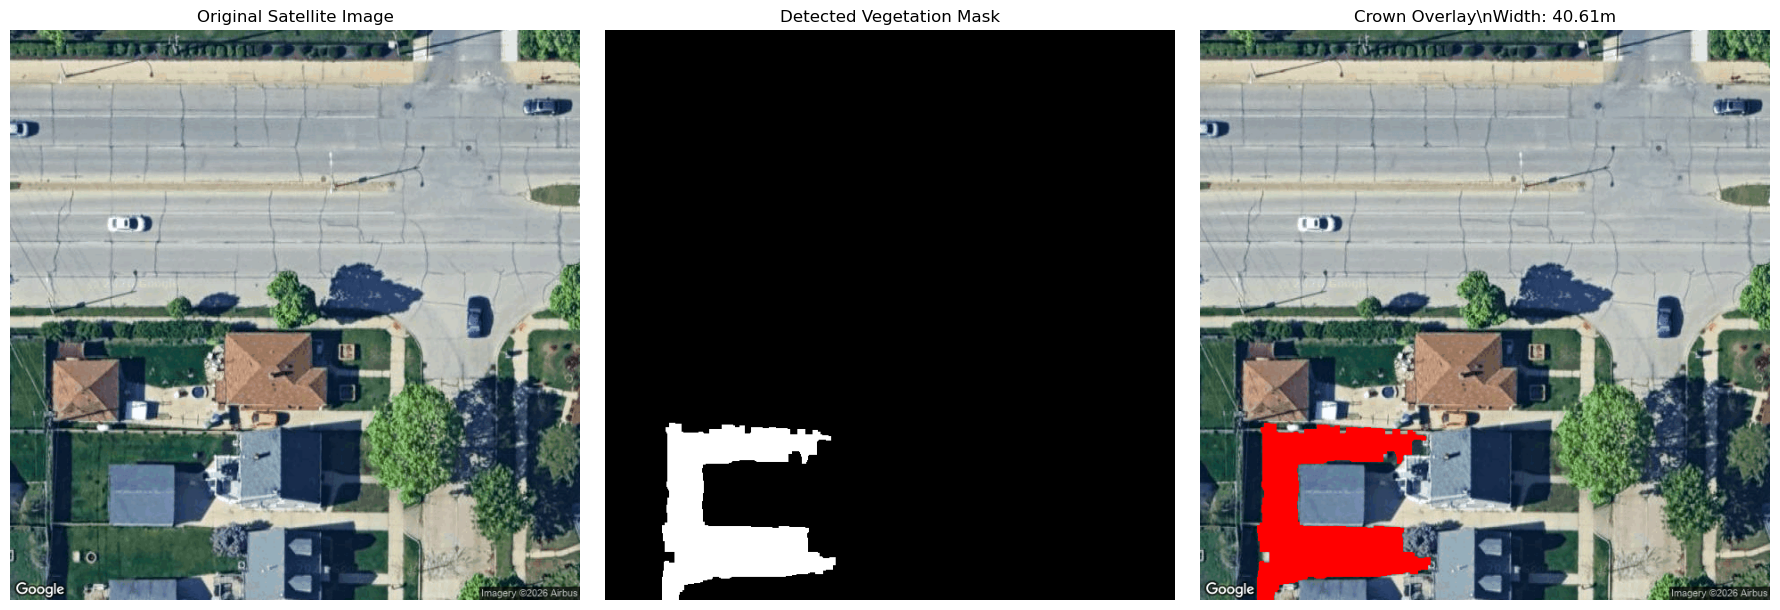

In [20]:
# Test crown detection on sample image
if test_image:
    crown_width, crown_mask, info = detect_tree_crown(
        test_image,
        sample_tree['Latitude'],
        sample_tree['Longitude'],
        ZOOM_LEVEL
    )
    
    if crown_width:
        print(f"✓ Crown detected!")
        print(f"\\nCrown Width: {crown_width:.2f} meters ({crown_width * 3.28084:.2f} feet)")
        print(f"\\nProcessing details:")
        for key, value in info.items():
            print(f"  {key}: {value}")
        
        # Visualize results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(test_image)
        axes[0].set_title('Original Satellite Image')
        axes[0].axis('off')
        
        # Vegetation mask
        axes[1].imshow(crown_mask, cmap='gray')
        axes[1].set_title('Detected Vegetation Mask')
        axes[1].axis('off')
        
        # Overlay - ensure image is RGB
        if test_image.mode != 'RGB':
            test_image_rgb = test_image.convert('RGB')
        else:
            test_image_rgb = test_image
        overlay = np.array(test_image_rgb).copy()
        # Ensure overlay is 3D (RGB) before assigning RGB values
        if len(overlay.shape) == 2:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        overlay[crown_mask > 0] = [255, 0, 0]  # Highlight crown in red
        axes[2].imshow(overlay)
        axes[2].set_title(f'Crown Overlay\\nWidth: {crown_width:.2f}m')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("✗ Could not detect crown. May need to adjust detection parameters.")
        if info:
            print(f"Info: {info}")
else:
    print("No test image available. Please fetch an image first.")


## Batch Processing

Process multiple trees and store crown width measurements. 

**Note:** Be mindful of API rate limits and costs when processing large batches.


In [ ]:
def process_tree_crown(site_id, lat, lon, zoom=ZOOM_LEVEL, api_key=GOOGLE_MAPS_API_KEY):
    """
    Complete pipeline: fetch image and extract crown width
    
    Returns:
    - crown_width_meters: Crown width in meters, or None if failed
    - success: Boolean indicating if processing succeeded
    """
    # Fetch satellite image
    image = get_satellite_image(lat, lon, zoom=zoom, api_key=api_key)
    
    if image is None:
        return None, False
    
    # Detect crown
    crown_width, crown_mask, info = detect_tree_crown(image, lat, lon, zoom)
    
    if crown_width is None:
        return None, False
    
    return crown_width, True

# Test on a small sample first
print("Testing batch processing on 5 sample trees...")
print("=" * 60)

sample_trees = tree_df.head(5).copy()
crown_widths = []

for idx, tree in sample_trees.iterrows():
    print(f"\\nProcessing Site ID {tree['Site ID']}...", end=' ')
    crown_width, success = process_tree_crown(
        tree['Site ID'],
        tree['Latitude'],
        tree['Longitude']
    )
    
    if success:
        crown_widths.append(crown_width)
        print(f"✓ Crown width: {crown_width:.2f}m")
    else:
        crown_widths.append(None)
        print("✗ Failed")

sample_trees['Crown_Width_Meters'] = crown_widths
print(f"\\n{'='*60}")
print(f"Successfully processed: {sum(1 for x in crown_widths if x is not None)}/{len(crown_widths)} trees")
print(f"\\nResults:")
print(sample_trees[['Site ID', 'Species_Simple', 'DBH', 'Crown_Width_Meters']])


## Advanced: Improved Crown Detection

The basic method above uses simple color thresholding. We can improve this with:
- Better color space analysis
- Edge detection
- Contour filtering by shape
- Machine learning segmentation (if needed)


In [ ]:
def detect_tree_crown_advanced(image, center_lat, center_lon, zoom_level, dbh=None):
    """
    Advanced crown detection with improved segmentation
    
    Parameters:
    - image: PIL Image
    - center_lat, center_lon: Image center coordinates
    - zoom_level: Zoom level
    - dbh: Tree DBH in inches (optional, for validation)
    
    Returns:
    - crown_width_meters: Crown width
    - processing_info: Detailed info
    """
    if image is None:
        return None, None
    
    # Convert PIL image to RGB if needed (handles palette mode, grayscale, etc.)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Convert PIL to numpy array (now guaranteed to be RGB)
    img_array = np.array(image)
    
    # Ensure we have 3 channels (RGB)
    if len(img_array.shape) == 2:
        # Grayscale image - convert to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4:
        # RGBA image - convert to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    
    h, w = img_array.shape[:2]
    center = (w // 2, h // 2)
    
    # Convert to multiple color spaces
    hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    
    # Enhanced green detection using multiple channels
    # HSV green range
    lower_green_hsv = np.array([35, 50, 50])
    upper_green_hsv = np.array([85, 255, 255])
    mask_hsv = cv2.inRange(hsv, lower_green_hsv, upper_green_hsv)
    
    # LAB green range (often better for vegetation)
    lower_green_lab = np.array([0, 100, 0])
    upper_green_lab = np.array([255, 255, 255])
    mask_lab = cv2.inRange(lab, lower_green_lab, upper_green_lab)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(mask_hsv, mask_lab)
    
    # Morphological operations
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((7, 7), np.uint8)
    
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_large)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_small)
    
    # Find contours
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None, {'error': 'No vegetation detected'}
    
    # Filter contours by:
    # 1. Size (reasonable for tree crown)
    # 2. Distance from center (tree should be near center)
    # 3. Shape (roughly circular/elliptical)
    
    m_per_pixel = meters_per_pixel(center_lat, zoom_level)
    
    # Estimate expected crown size from DBH if available
    # Typical crown width is 2-3x DBH for mature trees
    if dbh:
        expected_crown_meters = (dbh * 0.0254) * 2.5  # DBH in inches to meters, then 2.5x
        expected_crown_pixels = expected_crown_meters / m_per_pixel
        min_area = (expected_crown_pixels * 0.3) ** 2  # At least 30% of expected
        max_area = (expected_crown_pixels * 3.0) ** 2  # At most 3x expected
    else:
        min_area = 100  # Minimum pixels
        max_area = (w * h) * 0.3  # Max 30% of image
    
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Check distance from center
            M = cv2.moments(contour)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                dist_from_center = np.sqrt((cx - center[0])**2 + (cy - center[1])**2)
                max_dist = min(w, h) * 0.4  # Within 40% of image center
                if dist_from_center < max_dist:
                    valid_contours.append((contour, area, dist_from_center))
    
    if len(valid_contours) == 0:
        # Fallback: use largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        valid_contours = [(largest_contour, cv2.contourArea(largest_contour), 0)]
    
    # Select best contour (closest to center, reasonable size)
    best_contour = min(valid_contours, key=lambda x: x[2])[0]
    
    # Calculate crown width
    x, y, w_rect, h_rect = cv2.boundingRect(best_contour)
    crown_width_pixels = max(w_rect, h_rect)
    crown_width_meters = crown_width_pixels * m_per_pixel
    
    # Create mask
    crown_mask = np.zeros_like(combined_mask)
    cv2.drawContours(crown_mask, [best_contour], -1, 255, -1)
    
    info = {
        'crown_width_pixels': crown_width_pixels,
        'crown_width_meters': crown_width_meters,
        'meters_per_pixel': m_per_pixel,
        'contour_area_pixels': cv2.contourArea(best_contour),
        'bounding_box': (x, y, w_rect, h_rect),
        'num_contours_found': len(contours),
        'num_valid_contours': len(valid_contours)
    }
    
    return crown_width_meters, info

print("Advanced crown detection function ready!")


In [ ]:
# Compare basic vs advanced detection on sample
if test_image:
    print("Comparing detection methods...")
    print("=" * 60)
    
    # Basic method
    crown_basic, mask_basic, info_basic = detect_tree_crown(
        test_image, sample_tree['Latitude'], sample_tree['Longitude'], ZOOM_LEVEL
    )
    
    # Advanced method
    crown_advanced, info_advanced = detect_tree_crown_advanced(
        test_image, sample_tree['Latitude'], sample_tree['Longitude'], 
        ZOOM_LEVEL, dbh=sample_tree['DBH']
    )
    
    print(f"\\nBasic method: {crown_basic:.2f}m" if crown_basic else "Basic method: Failed")
    print(f"Advanced method: {crown_advanced:.2f}m" if crown_advanced else "Advanced method: Failed")
    
    if crown_basic and crown_advanced:
        print(f"\\nDifference: {abs(crown_basic - crown_advanced):.2f}m")
        
        # Visualize comparison
        fig, axes = plt.subplots(2, 2, figsize=(14, 14))
        
        # Original
        axes[0, 0].imshow(test_image)
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Basic mask
        if mask_basic is not None:
            axes[0, 1].imshow(mask_basic, cmap='gray')
            axes[0, 1].set_title(f'Basic Method\\nWidth: {crown_basic:.2f}m')
            axes[0, 1].axis('off')
        
        # Advanced (re-detect for visualization)
        crown_adv, info_adv = detect_tree_crown_advanced(
            test_image, sample_tree['Latitude'], sample_tree['Longitude'], 
            ZOOM_LEVEL, dbh=sample_tree['DBH']
        )
        # Recreate mask for visualization
        img_array = np.array(test_image)
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
        mask_hsv = cv2.inRange(hsv, np.array([35, 50, 50]), np.array([85, 255, 255]))
        mask_lab = cv2.inRange(lab, np.array([0, 100, 0]), np.array([255, 255, 255]))
        combined = cv2.bitwise_or(mask_hsv, mask_lab)
        axes[1, 0].imshow(combined, cmap='gray')
        axes[1, 0].set_title(f'Advanced Method\\nWidth: {crown_advanced:.2f}m')
        axes[1, 0].axis('off')
        
        # Overlay comparison - ensure image is RGB
        if test_image.mode != 'RGB':
            test_image_rgb = test_image.convert('RGB')
        else:
            test_image_rgb = test_image
        overlay = np.array(test_image_rgb).copy()
        # Ensure overlay is 3D (RGB) before assigning RGB values
        if len(overlay.shape) == 2:
            overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
        if mask_basic is not None:
            overlay[mask_basic > 0] = [255, 0, 0]  # Red for basic
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Comparison Overlay')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()


## Integration with Prioritization Model

Once we have crown width measurements, we can:
1. Add crown width as a feature to the prioritization model
2. Analyze correlation between crown width and tree failures
3. Use crown width to estimate tree health/stress


In [ ]:
# Example: Process a batch and save results
# Adjust NUM_SAMPLES based on API limits and testing needs

NUM_SAMPLES = 10  # Start small for testing
USE_ADVANCED = True  # Set to False for basic method

print(f"Processing {NUM_SAMPLES} trees for crown width extraction...")
print("=" * 60)

# Select sample trees (can be random or specific criteria)
sample_trees = tree_df.head(NUM_SAMPLES).copy()
crown_widths = []
success_flags = []

for idx, tree in sample_trees.iterrows():
    print(f"Processing Site ID {tree['Site ID']} ({idx+1}/{NUM_SAMPLES})...", end=' ')
    
    # Fetch image
    image = get_satellite_image(
        tree['Latitude'], 
        tree['Longitude'],
        zoom=ZOOM_LEVEL
    )
    
    if image is None:
        crown_widths.append(None)
        success_flags.append(False)
        print("✗ Image fetch failed")
        continue
    
    # Detect crown
    if USE_ADVANCED:
        crown_width, info = detect_tree_crown_advanced(
            image, tree['Latitude'], tree['Longitude'], 
            ZOOM_LEVEL, dbh=tree['DBH']
        )
    else:
        crown_width, mask, info = detect_tree_crown(
            image, tree['Latitude'], tree['Longitude'], ZOOM_LEVEL
        )
    
    if crown_width:
        crown_widths.append(crown_width)
        success_flags.append(True)
        print(f"✓ {crown_width:.2f}m")
    else:
        crown_widths.append(None)
        success_flags.append(False)
        print("✗ Detection failed")

# Add results to dataframe
sample_trees['Crown_Width_Meters'] = crown_widths
sample_trees['Crown_Width_Success'] = success_flags

print(f"\\n{'='*60}")
print(f"Successfully processed: {sum(success_flags)}/{NUM_SAMPLES} trees")
print(f"\\nResults summary:")
results_df = sample_trees[['Site ID', 'Species_Simple', 'DBH', 'Crown_Width_Meters', 'Crown_Width_Success']]
print(results_df[results_df['Crown_Width_Success'] == True])

# Save results
if sum(success_flags) > 0:
    output_file = '../../data/crown_width_measurements.csv'
    results_df.to_csv(output_file, index=False)
    print(f"\\n✓ Saved results to {output_file}")


## Analysis: Crown Width vs Tree Characteristics

Analyze relationships between crown width and other tree features


In [ ]:
# Analyze crown width relationships (if we have successful measurements)
if sum(success_flags) > 0:
    successful = sample_trees[sample_trees['Crown_Width_Success'] == True].copy()
    
    print("=== CROWN WIDTH ANALYSIS ===")
    print(f"\\nCrown width statistics:")
    print(successful['Crown_Width_Meters'].describe())
    
    # Crown width vs DBH
    if len(successful) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Scatter plot
        axes[0].scatter(successful['DBH'], successful['Crown_Width_Meters'], 
                       alpha=0.6, s=100, c='steelblue')
        axes[0].set_xlabel('DBH (inches)', fontsize=12)
        axes[0].set_ylabel('Crown Width (meters)', fontsize=12)
        axes[0].set_title('Crown Width vs DBH', fontsize=14, fontweight='bold')
        axes[0].grid(alpha=0.3)
        
        # Calculate correlation
        correlation = successful['DBH'].corr(successful['Crown_Width_Meters'])
        axes[0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=axes[0].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Crown width by species
        if successful['Species_Simple'].nunique() > 1:
            species_crown = successful.groupby('Species_Simple')['Crown_Width_Meters'].mean().sort_values(ascending=False)
            axes[1].barh(range(len(species_crown)), species_crown.values,
                        color=sns.color_palette("husl", len(species_crown)))
            axes[1].set_yticks(range(len(species_crown)))
            axes[1].set_yticklabels(species_crown.index, fontsize=10)
            axes[1].set_xlabel('Average Crown Width (meters)', fontsize=12)
            axes[1].set_title('Average Crown Width by Species', fontsize=14, fontweight='bold')
            axes[1].grid(axis='x', alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'Need multiple species\\nfor comparison', 
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\nCorrelation between DBH and Crown Width: {correlation:.3f}")
        print("\\nNote: Typical relationship is crown width ≈ 2-3x DBH for healthy trees")
else:
    print("No successful measurements to analyze. Please check API key and try again.")


## Notes and Next Steps

### Current Implementation:
- ✅ Google Maps Static API integration
- ✅ Basic crown detection using color thresholding
- ✅ Advanced detection with filtering
- ✅ Pixel-to-meter conversion
- ✅ Batch processing capability

### Potential Improvements:
1. **Better Segmentation:**
   - Use NDVI (Normalized Difference Vegetation Index) if available
   - Machine learning-based segmentation
   - Multi-temporal analysis (compare across seasons)

2. **API Alternatives:**
   - Google Earth Engine (free, more features)
   - Mapbox Satellite
   - Esri World Imagery
   - OpenStreetMap + other free sources

3. **Crown Detection Enhancements:**
   - Edge detection (Canny, Sobel)
   - Watershed segmentation
   - Template matching for specific tree shapes
   - Deep learning models (U-Net, etc.)

4. **Validation:**
   - Compare with ground truth measurements
   - Cross-validate with DBH (crown ≈ 2-3x DBH typically)
   - Manual review of edge cases

5. **Scale Up:**
   - Parallel processing for large batches
   - Caching images to avoid re-fetching
   - Rate limiting and error handling
   - Progress tracking

### Questions to Consider:
- What's the typical crown width range for your tree species?
- Do you have any ground truth measurements to validate against?
- What zoom level provides the best balance of detail vs coverage?
- Are there seasonal variations in crown visibility?


## Alternative: Google Earth Engine Implementation

Google Earth Engine offers:
- **Free** for research/education use
- Access to **Sentinel-2** (10m resolution) and **Landsat** (30m) imagery
- **NDVI** and other vegetation indices built-in
- **Historical imagery** for time series analysis
- Better for **large-scale batch processing**

**Setup Steps:**
1. Sign up at [earthengine.google.com](https://earthengine.google.com/)
2. Install: `pip install earthengine-api`
3. Authenticate: `earthengine authenticate` (one-time)
4. Initialize in code below


In [ ]:
# Google Earth Engine Implementation
# Uncomment and install: pip install earthengine-api

try:
    import ee
    EE_AVAILABLE = True
except ImportError:
    EE_AVAILABLE = False
    print("Google Earth Engine not installed. Install with: pip install earthengine-api")
    print("Then authenticate with: earthengine authenticate")

if EE_AVAILABLE:
    # Initialize Earth Engine (only need to do this once per session)
    try:
        ee.Initialize()
        print("✓ Google Earth Engine initialized successfully!")
    except Exception as e:
        print(f"⚠ Earth Engine not authenticated. Run: earthengine authenticate")
        print(f"Error: {e}")
        EE_AVAILABLE = False


In [ ]:
def get_satellite_image_gee(lat, lon, radius_meters=15, date_start='2023-06-01', date_end='2023-09-30'):
    """
    Fetch satellite image from Google Earth Engine
    
    Parameters:
    - lat, lon: Tree coordinates
    - radius_meters: Radius around tree in meters (default 15m = 30m diameter)
    - date_start, date_end: Date range for imagery (summer = better vegetation visibility)
    
    Returns:
    - PIL Image (RGB) or None if failed
    - Additional data: NDVI array, metadata
    """
    if not EE_AVAILABLE:
        return None, None
    
    try:
        # Create point geometry
        point = ee.Geometry.Point([lon, lat])
        region = point.buffer(radius_meters)
        
        # Use Sentinel-2 for better resolution (10m) and NDVI
        # Alternative: 'COPERNICUS/S2_SR_HARMONIZED' for newer data
        collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                     .filterBounds(region)
                     .filterDate(date_start, date_end)
                     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Low clouds
                     .sort('CLOUDY_PIXEL_PERCENTAGE')
                     .limit(1))  # Get least cloudy image
        
        # Get the best image
        image = ee.Image(collection.first())
        
        # Select RGB bands and compute NDVI
        rgb = image.select(['B4', 'B3', 'B2'])  # Red, Green, Blue (Sentinel-2)
        ndvi = image.normalizedDifference(['B8', 'B4'])  # NIR - Red / NIR + Red
        
        # Convert to RGB visualization (scale to 0-255)
        rgb_vis = rgb.visualize(
            min=0,
            max=3000,
            gamma=1.2
        )
        
        # Get image as numpy array
        rgb_array = np.array(rgb_vis.sampleRectangle(
            region=region,
            defaultValue=0
        ).get('vis-red'))
        
        # Earth Engine returns data in a specific format
        # We need to get all bands
        rgb_data = rgb_vis.sampleRectangle(region=region, defaultValue=0)
        red = np.array(rgb_data.get('vis-red'))
        green = np.array(rgb_data.get('vis-green'))
        blue = np.array(rgb_data.get('vis-blue'))
        
        # Stack into RGB image
        rgb_image = np.dstack([red, green, blue])
        
        # Normalize to 0-255
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-10)
        rgb_image = (rgb_image * 255).astype(np.uint8)
        
        # Get NDVI
        ndvi_data = ndvi.sampleRectangle(region=region, defaultValue=0)
        ndvi_array = np.array(ndvi_data.get('nd'))
        
        # Convert to PIL Image
        pil_image = Image.fromarray(rgb_image)
        
        return pil_image, {'ndvi': ndvi_array, 'date': image.get('system:time_start')}
        
    except Exception as e:
        print(f"Error fetching from Earth Engine: {e}")
        return None, None

def get_satellite_image_gee_simple(lat, lon, radius_meters=15):
    """
    Simpler Earth Engine function using Google's high-res imagery
    Similar resolution to Google Maps but free
    """
    if not EE_AVAILABLE:
        return None, None
    
    try:
        point = ee.Geometry.Point([lon, lat])
        region = point.buffer(radius_meters)
        
        # Use Google's high-resolution imagery (similar to Google Maps)
        image = ee.Image('GOOGLE/SATELLITE')
        
        # Get RGB
        rgb = image.select(['R', 'G', 'B'])
        
        # Sample region
        rgb_data = rgb.sampleRectangle(region=region, defaultValue=0)
        red = np.array(rgb_data.get('R'))
        green = np.array(rgb_data.get('G'))
        blue = np.array(rgb_data.get('B'))
        
        # Stack and normalize
        rgb_image = np.dstack([red, green, blue])
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-10)
        rgb_image = (rgb_image * 255).astype(np.uint8)
        
        return Image.fromarray(rgb_image), None
        
    except Exception as e:
        print(f"Error: {e}")
        return None, None

print("Google Earth Engine functions ready!")
print("\nNote: Earth Engine requires authentication. Run 'earthengine authenticate' first.")


In [ ]:
# Test Google Earth Engine (if available)
if EE_AVAILABLE:
    print("Testing Google Earth Engine...")
    print(f"Tree: Site ID {sample_tree['Site ID']}")
    print(f"Location: ({sample_tree['Latitude']:.6f}, {sample_tree['Longitude']:.6f})")
    
    # Try simple Google Satellite first (fastest, similar to Maps API)
    print("\n1. Fetching from Google Satellite (high-res)...")
    gee_image_simple, _ = get_satellite_image_gee_simple(
        sample_tree['Latitude'],
        sample_tree['Longitude'],
        radius_meters=15
    )
    
    if gee_image_simple:
        print(f"✓ Successfully fetched! Image size: {gee_image_simple.size}")
        
        plt.figure(figsize=(10, 10))
        plt.imshow(gee_image_simple)
        plt.title(f"Google Earth Engine - Google Satellite\\nSite ID: {sample_tree['Site ID']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("✗ Failed to fetch")
    
    # Try Sentinel-2 (with NDVI)
    print("\\n2. Fetching from Sentinel-2 (with NDVI)...")
    gee_image_s2, metadata = get_satellite_image_gee(
        sample_tree['Latitude'],
        sample_tree['Longitude'],
        radius_meters=15
    )
    
    if gee_image_s2:
        print(f"✓ Successfully fetched! Image size: {gee_image_s2.size}")
        if metadata and 'ndvi' in metadata:
            print(f"✓ NDVI available! Range: {metadata['ndvi'].min():.3f} to {metadata['ndvi'].max():.3f}")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].imshow(gee_image_s2)
        axes[0].set_title('Sentinel-2 RGB Image')
        axes[0].axis('off')
        
        if metadata and 'ndvi' in metadata:
            im = axes[1].imshow(metadata['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
            axes[1].set_title('NDVI (Normalized Difference Vegetation Index)')
            axes[1].axis('off')
            plt.colorbar(im, ax=axes[1], label='NDVI')
        
        plt.tight_layout()
        plt.show()
    else:
        print("✗ Failed to fetch Sentinel-2")
else:
    print("Google Earth Engine not available. Install and authenticate to use.")


## Enhanced Crown Detection with NDVI

Using NDVI from Earth Engine can significantly improve crown detection accuracy!


In [ ]:
def detect_tree_crown_ndvi(ndvi_array, center_lat, center_lon, zoom_level=None):
    """
    Detect tree crown using NDVI (much more accurate than color thresholding!)
    
    NDVI ranges:
    - -1 to 0: Water, buildings, roads
    - 0 to 0.3: Soil, dead vegetation
    - 0.3 to 0.6: Sparse vegetation, stressed trees
    - 0.6 to 1.0: Dense healthy vegetation (tree crowns!)
    
    Parameters:
    - ndvi_array: NDVI array from Earth Engine
    - center_lat, center_lon: For calculating meters_per_pixel (if needed)
    - zoom_level: Not used for GEE, but kept for compatibility
    
    Returns:
    - crown_width_meters: Crown width
    - crown_mask: Binary mask
    - processing_info: Details
    """
    if ndvi_array is None or ndvi_array.size == 0:
        return None, None, {'error': 'No NDVI data'}
    
    # Threshold for healthy vegetation (tree crowns)
    # NDVI > 0.5 typically indicates healthy vegetation
    vegetation_mask = (ndvi_array > 0.5).astype(np.uint8) * 255
    
    # Optional: Also include moderate vegetation (0.3-0.5) for stressed trees
    # vegetation_mask = ((ndvi_array > 0.3) & (ndvi_array <= 0.5)).astype(np.uint8) * 128
    
    # Clean up mask
    kernel = np.ones((5, 5), np.uint8)
    vegetation_mask = cv2.morphologyEx(vegetation_mask, cv2.MORPH_CLOSE, kernel)
    vegetation_mask = cv2.morphologyEx(vegetation_mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(vegetation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None, vegetation_mask, {'error': 'No vegetation detected'}
    
    # Find largest contour (main tree crown)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)
    crown_width_pixels = max(w, h)
    
    # Estimate meters per pixel
    # For Sentinel-2: ~10m per pixel at native resolution
    # For Google Satellite: varies, estimate based on image size
    # Rough estimate: if image is ~100 pixels across 30m, then ~0.3m per pixel
    image_size = max(ndvi_array.shape)
    estimated_area_meters = 30  # Assuming 30m x 30m area
    meters_per_pixel = estimated_area_meters / image_size
    crown_width_meters = crown_width_pixels * meters_per_pixel
    
    # Create crown mask
    crown_mask = np.zeros_like(vegetation_mask)
    cv2.drawContours(crown_mask, [largest_contour], -1, 255, -1)
    
    info = {
        'crown_width_pixels': crown_width_pixels,
        'crown_width_meters': crown_width_meters,
        'meters_per_pixel': meters_per_pixel,
        'ndvi_mean': float(ndvi_array[crown_mask > 0].mean()) if crown_mask.sum() > 0 else 0,
        'ndvi_max': float(ndvi_array.max()),
        'ndvi_min': float(ndvi_array.min()),
        'contour_area_pixels': cv2.contourArea(largest_contour),
        'bounding_box': (x, y, w, h)
    }
    
    return crown_width_meters, crown_mask, info

print("NDVI-based crown detection ready!")
print("\\nNote: NDVI is much more accurate than color thresholding for vegetation detection!")


In [ ]:
# Compare all three methods if available
if EE_AVAILABLE:
    print("=== COMPARING DETECTION METHODS ===")
    print("=" * 60)
    
    # Get Sentinel-2 image with NDVI
    gee_image, metadata = get_satellite_image_gee(
        sample_tree['Latitude'],
        sample_tree['Longitude'],
        radius_meters=15
    )
    
    if gee_image and metadata and 'ndvi' in metadata:
        # Method 1: NDVI-based (most accurate)
        crown_ndvi, mask_ndvi, info_ndvi = detect_tree_crown_ndvi(
            metadata['ndvi'],
            sample_tree['Latitude'],
            sample_tree['Longitude']
        )
        
        # Method 2: Color-based on GEE image
        crown_color, mask_color, info_color = detect_tree_crown(
            gee_image,
            sample_tree['Latitude'],
            sample_tree['Longitude'],
            zoom_level=20  # Approximate
        )
        
        print(f"\\nNDVI Method: {crown_ndvi:.2f}m" if crown_ndvi else "NDVI Method: Failed")
        print(f"Color Method: {crown_color:.2f}m" if crown_color else "Color Method: Failed")
        
        if crown_ndvi:
            print(f"\\nNDVI Statistics:")
            print(f"  Mean NDVI in crown: {info_ndvi['ndvi_mean']:.3f}")
            print(f"  NDVI range: {info_ndvi['ndvi_min']:.3f} to {info_ndvi['ndvi_max']:.3f}")
        
        # Visualize comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Row 1: Images
        axes[0, 0].imshow(gee_image)
        axes[0, 0].set_title('Sentinel-2 RGB')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(metadata['ndvi'], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[0, 1].set_title('NDVI Map')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(gee_image)
        if mask_ndvi is not None:
            # Ensure image is RGB before creating overlay
            if gee_image.mode != 'RGB':
                gee_image_rgb = gee_image.convert('RGB')
            else:
                gee_image_rgb = gee_image
            overlay = np.array(gee_image_rgb).copy()
            # Ensure overlay is 3D (RGB) before assigning RGB values
            if len(overlay.shape) == 2:
                overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
            overlay[mask_ndvi > 0] = [255, 0, 0]
            axes[0, 2].imshow(overlay)
        axes[0, 2].set_title(f'NDVI Detection\\nWidth: {crown_ndvi:.2f}m' if crown_ndvi else 'NDVI Detection')
        axes[0, 2].axis('off')
        
        # Row 2: Masks and comparison
        if mask_ndvi is not None:
            axes[1, 0].imshow(mask_ndvi, cmap='gray')
            axes[1, 0].set_title('NDVI Mask')
            axes[1, 0].axis('off')
        
        if mask_color is not None:
            axes[1, 1].imshow(mask_color, cmap='gray')
            axes[1, 1].set_title('Color Mask')
            axes[1, 1].axis('off')
        
        # Combined overlay
        combined = np.array(gee_image).copy()
        if mask_ndvi is not None:
            combined[mask_ndvi > 0] = [255, 0, 0]  # Red for NDVI
        if mask_color is not None:
            combined[mask_color > 0] = [0, 255, 0]  # Green for color
        axes[1, 2].imshow(combined)
        axes[1, 2].set_title('Comparison Overlay\\nRed=NDVI, Green=Color')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\\n" + "=" * 60)
        print("Recommendation: NDVI method is typically more accurate for vegetation detection!")
    else:
        print("Could not fetch Sentinel-2 imagery. Check authentication and region.")
else:
    print("Google Earth Engine not available for comparison.")


## Summary: Which Should You Use?

### **Google Maps Static API** - Best for:
- ✅ Quick setup and prototyping
- ✅ Highest resolution (0.1-0.5m) for individual trees
- ✅ Simple HTTP requests
- ✅ Good for small batches (< 1000 trees)

### **Google Earth Engine** - Best for:
- ✅ **Free** for research/education
- ✅ **NDVI** for accurate vegetation detection
- ✅ Historical imagery and time series
- ✅ Large-scale batch processing (1000s of trees)
- ✅ Scientific analysis and research

### **Recommendation:**
1. **Start with Google Maps Static API** for initial testing and validation
2. **Switch to Google Earth Engine** for:
   - Large-scale processing
   - When you need NDVI for better accuracy
   - Historical analysis
   - Research/publication work

### **Hybrid Approach:**
- Use **Google Maps** for high-res validation samples
- Use **Earth Engine** for bulk processing with NDVI
- Compare results to validate accuracy
